<a href="https://colab.research.google.com/github/NSR9/PythonForML-AI-Notes/blob/master/S7/S7_nsr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



(50000, 32, 32, 3)
76800.0
torch.Size([64, 3, 32, 32])
torch.Size([64])
horse plane plane horse


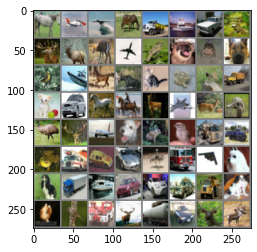

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
size = trainset.data.size
shape = trainset.data.shape
print(shape)
print(size/2000)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, input, output, padding=0, bias=False):
        super(DepthwiseSeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(input, input, kernel_size=3, padding=padding, groups=input, bias=bias)
        self.pointwise = nn.Conv2d(input, output, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolution block - 1
        self.conv1 = nn.Sequential( nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (3,3), padding = 1,  bias = False),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(16)) # size = 32  rf = 3
        
        self.conv2 = nn.Sequential( nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), padding = 1,bias = False),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(32)) # size = 32  rf = 5
        
        
         #Dilated convolution
         
        self.dilatedconv1 = nn.Sequential( nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (3,3), padding = 2, dilation = 2, bias = False),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(32)) # size = 32  rf = 9
                             
        self.dilatedconv2 = nn.Sequential( nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3,3), padding = 1, dilation = 2, bias = False),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(64))# size = 30  rf = 13


        
        # Maxpooling-1 and Transition block - 1
        self.pool1 = nn.MaxPool2d(2, 2) # size = 15  rf= 13+(1)*1 = 14
        self.transition1 = nn.Sequential( nn.Conv2d(in_channels = 64, out_channels = 16, kernel_size = (1,1), padding = 0, bias = False),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(16)) # size = 15  rf = 14




        #Convolution block - 2 
        self.conv3 = nn.Sequential( nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), padding = 1, bias = False),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(32))# size = 15  rf = 18
    
        #Dilated convolution
        self.dilatedconv3 = nn.Sequential( nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3,3), padding = 2,dilation = 2, bias = False),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(64)) # size = 15  rf = 26      

        
        self.conv4 = nn.Sequential( nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3,3), padding = 1, bias = False),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(128))# size = 15  rf = 28





        #Maxpooling-2 and Transition block - 2
        self.pool2 = nn.MaxPool2d(2,2) #Size = 7    rf = 30
        self.transition2 = nn.Sequential( nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = (1,1), padding = 0, bias = False),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(32)) # size = 7  rf = 30                       
        




        #Convolution block - 3 

        #Depth wise seperable convolution implemented.
        self.conv5 = nn.Sequential( #nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3,3), padding = 1, bias = False),
                                    DepthwiseSeparableConv2d(32, 64, padding = 1, bias = False),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(64)) # size = 7  rf = 38
        
        self.conv6 = nn.Sequential( nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3,3), padding = 1, bias = False),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(128)) # size = 7  rf = 46
                                   
        self.conv7 = nn.Sequential(nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3,3), padding = 1, bias = False),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(256))# size = 7  rf = 54





        #Maxpooling - 3 and Transition block - 3
        self.pool3 = nn.MaxPool2d(2,2)# size = 3  rf = 58
        self.transition3 = nn.Sequential( nn.Conv2d(in_channels = 256, out_channels = 64, kernel_size = (1,1), padding = 0, bias = False),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(64)) # size = 3  rf = 58





        #Convolution block - 4
        self.conv8 = nn.Sequential( nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3,3), padding = 1, bias = False)) # size = 3  
        self.conv9 = nn.Sequential( nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3,3), padding = 1, bias = False))  # size = 3  


        #Global average pooling
        self.gap = nn.Sequential(nn.AvgPool2d(3)) # Global Average Pooling

        self.drop = nn.Sequential(nn.Dropout(0.10))


        #Fully connected layers.
        self.fc1 = nn.Linear(256*1*1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
       
       
        x = self.conv1(x)
        x = self.drop(x)
        x = self.conv2(x)
        x = self.drop(x)
        x = self.dilatedconv1(x)
        x = self.drop(x)
        x = self.dilatedconv2(x)
        x = self.drop(x)


        x = self.pool1(x)
        x = self.transition1(x)
        x = self.drop(x)



        x = self.conv3(x)
        x = self.drop(x)
        x = self.dilatedconv3(x)
        x = self.drop(x)
        x = self.conv4(x)
        x = self.drop(x)



        x = self.pool2(x)
        x = self.transition2(x)
        x = self.drop(x)




        x = self.conv5(x)
        x = self.drop(x)
        x = self.conv6(x)
        x = self.drop(x)
        x = self.conv7(x)
        x = self.drop(x)



        x = self.pool3(x)
        x = self.transition3(x)
        x = self.drop(x)



        x = self.conv8(x)
        x = self.drop(x)
        x = self.conv9(x)
        



        x = self.gap(x)



        x = x.view(-1,256*1*1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
      
        return F.log_softmax(x, dim = -1)


net = Net()

In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()

if use_cuda:
  device = torch.device("cuda:0")
  print("running on GPU")
else:
  device = torch.device("cpu")
  print("runnning on CPU")  
#device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

running on GPU
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,216
             ReLU-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
          Dropout-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 30, 30]          18,432
             ReLU-14    

In [0]:
from tqdm import tqdm
import numpy as np

class Test_Train():
  def __init__(self):

# # This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, model, device, trainloader, optimizer, epoch,scheduler, L1lambda=None):
    model.train()    # prepare model for training
    pbar = tqdm(trainloader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()    # clear the gradients of all optimized variables
      
      # Predict
      y_pred = model(data)   # forward pass

      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      #Implementing L1 Regularization
      if L1lambda:
        with torch.enable_grad():
          l1_loss = 0.

          
          for param in model.parameters():
            l1_loss += torch.sum(param.abs())
          loss += L1lambda * l1_loss

      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
      self.train_epoch_end.append(self.train_acc[-1])


  def test(self, model, device, test_loader,filename):
      model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()  
      test_loss /= len(testloader.dataset)
      self.test_losses.append(test_loss)

      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min, test_loss))
          torch.save(model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(testloader.dataset),
          100. * correct / len(testloader.dataset)))
    
      self.test_acc.append(100. * correct / len(testloader.dataset))


3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [0]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
#criterion = nn.CrossEntropyLoss() # iccommented this line to increase the accuracy
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # in this line, net.parameters() is changed to model.parameters() then the accuracy improved
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(trainloader), epochs=25)

In [14]:
model1 = Test_Train()
EPOCHS = 15
for epoch in range(1,EPOCHS+1):
  print("EPOCH:", epoch)
  model1.train(model, device, trainloader, optimizer, epoch, scheduler)
  model1.test(model, device, testloader,"model.pt")

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.3965328931808472 Batch_id=781 Accuracy=26.21: 100%|██████████| 782/782 [00:42<00:00, 18.40it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 1.5833).  Saving model ...

Test set: Average loss: 1.5833, Accuracy: 4086/10000 (40.86%)

EPOCH: 2


Loss=1.0003612041473389 Batch_id=781 Accuracy=50.15: 100%|██████████| 782/782 [00:42<00:00, 18.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss has  decreased (1.5833 --> 1.2730).  Saving model ...

Test set: Average loss: 1.2730, Accuracy: 5418/10000 (54.18%)

EPOCH: 3


Loss=1.0400488376617432 Batch_id=781 Accuracy=58.77: 100%|██████████| 782/782 [00:42<00:00, 18.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss has  decreased (1.2730 --> 1.1769).  Saving model ...

Test set: Average loss: 1.1769, Accuracy: 5766/10000 (57.66%)

EPOCH: 4


Loss=0.8908779621124268 Batch_id=781 Accuracy=64.64: 100%|██████████| 782/782 [00:41<00:00, 18.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss has  decreased (1.1769 --> 1.0884).  Saving model ...

Test set: Average loss: 1.0884, Accuracy: 6449/10000 (64.49%)

EPOCH: 5


Loss=1.5500106811523438 Batch_id=781 Accuracy=68.96: 100%|██████████| 782/782 [00:41<00:00, 18.69it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss has  decreased (1.0884 --> 0.9364).  Saving model ...

Test set: Average loss: 0.9364, Accuracy: 6744/10000 (67.44%)

EPOCH: 6


Loss=1.1673645973205566 Batch_id=781 Accuracy=71.65: 100%|██████████| 782/782 [00:42<00:00, 18.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss has  decreased (0.9364 --> 0.8714).  Saving model ...

Test set: Average loss: 0.8714, Accuracy: 7096/10000 (70.96%)

EPOCH: 7


Loss=0.41807815432548523 Batch_id=781 Accuracy=73.82: 100%|██████████| 782/782 [00:42<00:00, 18.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss has  decreased (0.8714 --> 0.8194).  Saving model ...

Test set: Average loss: 0.8194, Accuracy: 7402/10000 (74.02%)

EPOCH: 8


Loss=0.2350357472896576 Batch_id=781 Accuracy=75.50: 100%|██████████| 782/782 [00:42<00:00, 18.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss has  decreased (0.8194 --> 0.7499).  Saving model ...

Test set: Average loss: 0.7499, Accuracy: 7539/10000 (75.39%)

EPOCH: 9


Loss=1.581130027770996 Batch_id=781 Accuracy=76.60: 100%|██████████| 782/782 [00:42<00:00, 18.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss has  decreased (0.7499 --> 0.6641).  Saving model ...

Test set: Average loss: 0.6641, Accuracy: 7833/10000 (78.33%)

EPOCH: 10


Loss=1.3798820972442627 Batch_id=781 Accuracy=77.89: 100%|██████████| 782/782 [00:42<00:00, 18.56it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6654, Accuracy: 7816/10000 (78.16%)

EPOCH: 11


Loss=0.8985545635223389 Batch_id=781 Accuracy=79.10: 100%|██████████| 782/782 [00:42<00:00, 18.49it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7177, Accuracy: 7640/10000 (76.40%)

EPOCH: 12


Loss=0.5278574228286743 Batch_id=781 Accuracy=80.03: 100%|██████████| 782/782 [00:42<00:00, 18.57it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7421, Accuracy: 7663/10000 (76.63%)

EPOCH: 13


Loss=0.2705477178096771 Batch_id=781 Accuracy=81.20: 100%|██████████| 782/782 [00:41<00:00, 18.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss has  decreased (0.6641 --> 0.6393).  Saving model ...

Test set: Average loss: 0.6393, Accuracy: 7888/10000 (78.88%)

EPOCH: 14


  0%|          | 0/782 [00:00<?, ?it/s]

Validation loss has  decreased (0.6393 --> 0.6052).  Saving model ...

Test set: Average loss: 0.6052, Accuracy: 8048/10000 (80.48%)

EPOCH: 15


Loss=0.8999242186546326 Batch_id=781 Accuracy=82.97: 100%|██████████| 782/782 [00:41<00:00, 18.65it/s]



Test set: Average loss: 0.6144, Accuracy: 8056/10000 (80.56%)

